<a href="https://colab.research.google.com/github/Dexter0526/Algorithm/blob/master/ch12/ex04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 양방향 LSTM과 CRF(Bidirectional LSTM + CRF)

In [1]:
!head -n 3 /proc/meminfo

MemTotal:       13335188 kB
MemFree:        10829264 kB
MemAvailable:   12518584 kB


In [2]:
pip install keras==2.2.4

     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [3]:
# CRF
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-yokeys1a
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-yokeys1a
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=613d99bb595ff54e98cd18611da7c11617411ca7d9329c159a69d214aa1aa1ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-woezo_0u/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [5]:
# 구글 연동
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### 개체명 인식 데이터에 대한 이해와 전처리

In [0]:
# 데이터 읽기
data = pd.read_csv(r"/content/drive/My Drive/dataset/ner_dataset.csv", encoding="latin1")

In [7]:
data.head(5)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [8]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


In [9]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


In [10]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [11]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [12]:
print('Tag 열의 각각의 값을 개수 카운트')
print('===========================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값을 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [0]:
data = data.fillna(method='ffill')

In [14]:
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [15]:
print('데이터에 Null 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 유무 : False


In [16]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [17]:
print(data[:10])

    Sentence #           Word  POS    Tag
0  Sentence: 1      thousands  NNS      O
1  Sentence: 1             of   IN      O
2  Sentence: 1  demonstrators  NNS      O
3  Sentence: 1           have  VBP      O
4  Sentence: 1        marched  VBN      O
5  Sentence: 1        through   IN      O
6  Sentence: 1         london  NNP  B-geo
7  Sentence: 1             to   TO      O
8  Sentence: 1        protest   VB      O
9  Sentence: 1            the   DT      O


In [18]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


In [19]:
print(tagged_sentences[0])

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [0]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [21]:
print(sentences[1])
print(ner_tags[1])

['iranian', 'officials', 'say', 'they', 'expect', 'to', 'get', 'access', 'to', 'sealed', 'sensitive', 'parts', 'of', 'the', 'plant', 'wednesday', ',', 'after', 'an', 'iaea', 'surveillance', 'system', 'begins', 'functioning', '.']
['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O']


In [22]:
print(sentences[95])
print(ner_tags[95])

['zapatista', 'leader', 'subcomandante', 'marcos', 'friday', 'announced', 'the', 'death', 'of', 'comandante', 'ramona', ',', 'saying', 'mexico', 'had', 'lost', 'a', 'fighter', 'and', 'the', 'zapatistas', 'had', 'lost', 'a', 'piece', 'of', 'their', 'heart', '.']
['B-geo', 'O', 'B-geo', 'I-geo', 'B-tim', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


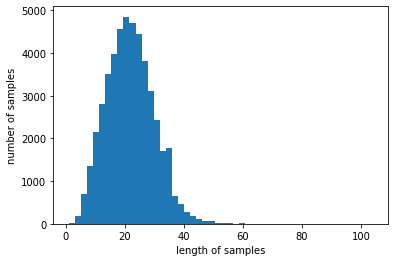

In [23]:
print('샘플의 최대 길이 : %d' %max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' %(sum(map(len, sentences)) / len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [0]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [25]:
vocab_size = len(src_tokenzier.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [26]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenzier.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [0]:
X_train = src_tokenzier.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [28]:
print(X_train[1])
print(y_train[1])

[327, 36, 27, 48, 1773, 7, 766, 1005, 7, 4424, 3184, 771, 6, 2, 1165, 84, 4, 43, 25, 1650, 2189, 454, 2190, 6016, 3]
[8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1]


In [0]:
index_to_word = src_tokenzier.index_word
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [30]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [31]:
decoded = []
for index in X_train[0]:
  decoded.append(index_to_word[index])

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [0]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=777)

In [0]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [35]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


### 양방향 LSTM + CRF를 이용한 개체명 인식

In [36]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

Using TensorFlow backend.


In [37]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=20, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(50, activation="relu")))
crf = CRF(tag_size)
model.add(crf)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.1, verbose=1)

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '





Train on 34530 samples, validate on 3837 samples
Epoch 1/5





34530/34530 [==============================] - 177s 5ms/step - loss: 8.3959 - crf_viterbi_accuracy: 0.8877 - val_loss: 8.2151 - val_crf_viterbi_accuracy: 0.9138
Epoch 2/5
34530/34530 [==============================] - 172s 5ms/step - loss: 8.1420 - crf_viterbi_accuracy: 0.9441 - val_loss: 8.1111 - val_crf_viterbi_accuracy: 0.9488
Epoch 3/5
34530/34530 [==============================] - 173s 5ms/step - loss: 8.1016 - crf_viterbi_accuracy: 0.9549 - val_loss: 8.0960 - val_crf_viterbi_accuracy: 0.9497
Epoch 4/5
34530/34530 [==============================] - 172s 5ms/step - loss: 8.0854 - crf_viterbi_accuracy: 0.9594 - val_loss: 8.0870 - val_crf_viterbi_accuracy: 0.9522
Epoch 5/5
34530/34530 [==============================] - 172s 5ms/step - loss: 8.0766 - crf_viterbi_accuracy: 0.9623 - val_loss: 8.0787 - val_crf_viterbi_accuracy: 0.9570


In [39]:
print("\n 테스트 정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

9592/9592 [==============================] - 13s 1ms/step

 테스트 정확도 : 0.9581


In [40]:
i = 13
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis = -1)
true = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
  if w != 0:
    print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


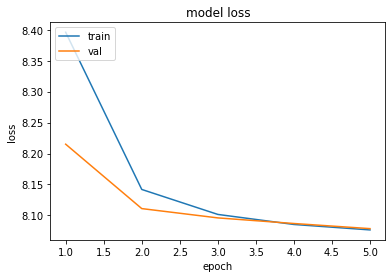

In [41]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 시퀀스 레이블링 평가하기

In [42]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
# 실제값
predicted=['O'] * len(true) #실제값의 길이만큼 전부 'O'로 채워진 리스트 생성. 예측값으로 사용.
print(predicted)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [43]:
hit = 0 # 정답 개수
for t, p in zip(true, predicted):
  if t == p:
    hit += 1
accuracy = hit/len(true) # 정답 개수를 총 개수로 나눈다.
print("정확도: {:.1%}".format(accuracy))

정확도: 74.4%


In [44]:
pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=6cd87bf08c190ac3ac971203004c3264162b52b540da57865aaa0011739a5cc8
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [45]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print(classification_report(true, predicted))

           precision    recall  f1-score   support

     MISC       0.00      0.00      0.00         2
      PER       0.00      0.00      0.00         3

micro avg       0.00      0.00      0.00         5
macro avg       0.00      0.00      0.00         5



In [46]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O']
print(classification_report(true, predicted))

           precision    recall  f1-score   support

     MISC       1.00      0.50      0.67         2
      PER       1.00      0.67      0.80         3

micro avg       1.00      0.60      0.75         5
macro avg       1.00      0.60      0.75         5



### 실제 모델에 대해서 f1 score 구하기

In [0]:
def sequences_to_tag(sequences): # 예측값을 index_to_tag를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [0]:
y_predicted = model.predict(X_test)
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [50]:
print(classification_report(test_tags, pred_tags))

           precision    recall  f1-score   support

      geo       0.80      0.88      0.84      7620
      gpe       0.97      0.92      0.95      3145
      tim       0.90      0.78      0.84      4067
      per       0.78      0.75      0.76      3545
      org       0.69      0.53      0.60      4033
      art       0.00      0.00      0.00        63
      nat       0.00      0.00      0.00        37
      eve       1.00      0.02      0.04        52

micro avg       0.82      0.78      0.80     22562
macro avg       0.81      0.78      0.79     22562



In [51]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 80.0%


### 새로운 입력에 대해서 예측하기

In [0]:
word_to_index = src_tokenizer.word_index
new_sentence='Hong Gildong starts over with the Justice League of Joseon at the country of Yul'.split()

In [55]:
new_X=[]
for w in new_sentence:
    try:
      new_X.append(word_to_index.get(w,1))
    except KeyError:
      new_X.append(word_to_index['OOV'])
      # 모델이 모르는 단어에 대해서는 'OOV'의 인덱스인 1로 인코딩

print(new_X)

[1, 1, 4027, 80, 17, 2, 1, 1, 6, 1, 20, 2, 56, 6, 1]


In [0]:
pad_new = pad_sequences([new_X], padding="post", value=0, maxlen=max_len)

In [78]:
p = model.predict(np.array([pad_new[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("단어", "예측값"))
print(30 * "=")
for w, pred in zip(new_sentence, p[0]):
    print("{:15}: {:5}".format(w, index_to_ner[pred]))

단어             ||예측값
Hong           : B-per
Gildong        : I-per
starts         : O    
over           : O    
with           : O    
the            : O    
Justice        : O    
League         : O    
of             : O    
Joseon         : O    
at             : O    
the            : O    
country        : O    
of             : O    
Yul            : O    
